In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shutil

In [10]:
def delete_ipynb_checkpoints(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for d in dirs:
            if d == ".ipynb_checkpoints":
                path = os.path.join(root, d)
                print(f"🗑️ Suppression de : {path}")
                shutil.rmtree(path)

# Exécuter cette fonction avant d'appeler load_data
delete_ipynb_checkpoints("tifinagh_raw")

🗑️ Suppression de : tifinagh_raw\.ipynb_checkpoints
🗑️ Suppression de : tifinagh_raw\yaz\.ipynb_checkpoints


In [12]:
def load_data_from_tifinagh_raw(data_dir='tifinagh_raw', batch_size=32, train_split=0.8):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    total_size = len(dataset)
    train_size = int(train_split * total_size)
    test_size = total_size - train_size
    train_ds, test_ds = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, dataset.classes

In [13]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=33):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [14]:
def train_model(model, train_loader, test_loader, device, lr=0.001, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds += predicted.cpu().tolist()
                all_labels += labels.cpu().tolist()

        acc = correct / total
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1} - Loss: {train_losses[-1]:.4f} - Accuracy: {acc:.4f}")

    # Courbes
    plt.plot(train_losses, label='Loss')
    plt.plot(test_accuracies, label='Accuracy')
    plt.legend()
    plt.title("Training Performance")
    plt.grid()
    plt.show()

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

Classes: ['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagg', 'yagh', 'yah', 'yahh', 'yaj', 'yak', 'yakk', 'yal', 'yam', 'yan', 'yaq', 'yar', 'yarr', 'yas', 'yass', 'yat', 'yatt', 'yaw', 'yax', 'yay', 'yaz', 'yazz', 'yey', 'yi', 'yu']
Epoch 1 - Loss: 1.7269 - Accuracy: 0.6823
Epoch 2 - Loss: 0.6664 - Accuracy: 0.8451
Epoch 3 - Loss: 0.3768 - Accuracy: 0.8861
Epoch 4 - Loss: 0.2612 - Accuracy: 0.9177
Epoch 5 - Loss: 0.1950 - Accuracy: 0.9402
Epoch 6 - Loss: 0.1609 - Accuracy: 0.9315
Epoch 7 - Loss: 0.1335 - Accuracy: 0.9384
Epoch 8 - Loss: 0.1145 - Accuracy: 0.9489
Epoch 9 - Loss: 0.0976 - Accuracy: 0.9432
Epoch 10 - Loss: 0.0917 - Accuracy: 0.9599


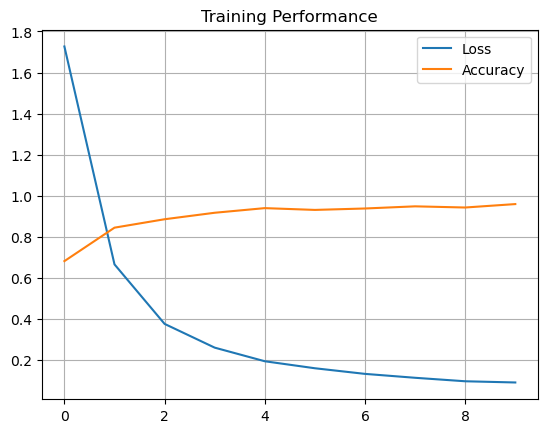

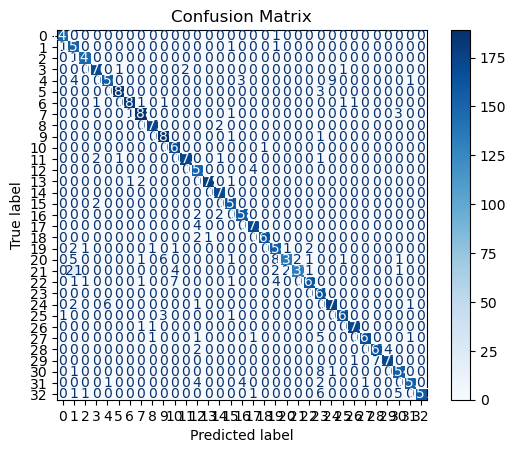

In [15]:
if __name__ == "__main__":
    train_loader, test_loader, class_names = load_data_from_tifinagh_raw("tifinagh_raw")
    print(f"Classes: {class_names}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LeNet5(num_classes=len(class_names)).to(device)
    train_model(model, train_loader, test_loader, device)